### ANN for regression, example 1, house energy bill estimation

In [86]:
# pip install scikit-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics

# pip install tensorflow
import tensorflow as tf
import keras
from keras import layers

Loading the data and checking it


In [87]:
data = pd.read_csv("CO2 Emissions_Canada.csv")

In [88]:
data.head()

,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
0,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244


In [89]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7385 entries, 0 to 7384
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Make                              7385 non-null   object 
 1   Model                             7385 non-null   object 
 2   Vehicle Class                     7385 non-null   object 
 3   Engine Size(L)                    7385 non-null   float64
 4   Cylinders                         7385 non-null   int64  
 5   Transmission                      7385 non-null   object 
 6   Fuel Type                         7385 non-null   object 
 7   Fuel Consumption City (L/100 km)  7385 non-null   float64
 8   Fuel Consumption Hwy (L/100 km)   7385 non-null   float64
 9   Fuel Consumption Comb (L/100 km)  7385 non-null   float64
 10  Fuel Consumption Comb (mpg)       7385 non-null   int64  
 11  CO2 Emissions(g/km)               7385 non-null   int64  
dtypes: flo

#Remember ALL DATA HAS TO BE NUMERIC FOR THE ML MODEL INCLUDING NN

In [90]:
data.isnull().sum()

Make                                0
Model                               0
Vehicle Class                       0
Engine Size(L)                      0
Cylinders                           0
Transmission                        0
Fuel Type                           0
Fuel Consumption City (L/100 km)    0
Fuel Consumption Hwy (L/100 km)     0
Fuel Consumption Comb (L/100 km)    0
Fuel Consumption Comb (mpg)         0
CO2 Emissions(g/km)                 0
dtype: int64

In [91]:
data.duplicated().sum()
#we don't want duplicates because it adds bias to the data

np.int64(1103)

In [92]:
data = data.drop_duplicates()

In [93]:
data.columns

Index(['Make', 'Model', 'Vehicle Class', 'Engine Size(L)', 'Cylinders', 'Transmission', 'Fuel Type', 'Fuel Consumption City (L/100 km)', 'Fuel Consumption Hwy (L/100 km)', 'Fuel Consumption Comb (L/100 km)', 'Fuel Consumption Comb (mpg)', 'CO2 Emissions(g/km)'], dtype='object')

In [94]:
data_numeric = data.select_dtypes(include=[np.number])
data_categorical = data.select_dtypes(include=[object])

In [95]:
data_categorical.describe()

,Make,Model,Vehicle Class,Transmission,Fuel Type
count,6282,6282,6282,6282,6282
unique,42,2053,16,27,5
top,FORD,F-150 FFV,SUV - SMALL,AS6,X
freq,577,32,1006,1139,3039


In [ ]:
data['Transmission'].value_counts()

In [ ]:
data['Vehicle Class'].value_counts()

I chose to regroup the transmission et vehicle class in more general groups so i can reduce the size and i chose to remove Model because of its high cardinality

In [ ]:
data["transmission_group"] = data["Transmission"].str.extract(r"([A-Z]+)") # I used AI here because i want to extract the letters from the string and i'm not very good with regex
data.drop(columns=["Transmission"], inplace=True)

def map_vehicle_class(vc):
    if "SUV" in vc:
        return "SUV"
    elif "PICKUP TRUCK" in vc:
        return "Pickup Truck"
    elif "STATION WAGON" in vc:
        return "Station Wagon"
    elif "VAN" in vc:
        return "Van"
    elif "MINIVAN" in vc:
        return "Van"
    elif vc in ["COMPACT","SUBCOMPACT","MINICOMPACT","MID-SIZE","TWO-SEATER"]:
        return "Car"
    elif vc in ["FULL-SIZE","SPECIAL PURPOSE VEHICLE"]:
        return "Other"
    else:
        return "Other"

data["Vehicle_Class_Reduced"] = data["Vehicle Class"].apply(map_vehicle_class)
data.drop(columns=["Vehicle Class","Model"], inplace=True)

data.describe(include='object')

,Make,Fuel Type,transmission_group,Vehicle_Class_Reduced
count,6282,6282,6282,6282
unique,42,5,5,6
top,FORD,X,AS,Car
freq,577,3039,2722,3074


In [97]:
data_numeric.describe()

,Engine Size(L),Cylinders,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
count,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000
mean,3.161812,5.618911,12.610220,9.070583,11.017876,27.411016,251.157752
std,1.365201,1.846250,3.553066,2.278884,2.946876,7.245318,59.290426
min,0.900000,3.000000,4.200000,4.000000,4.100000,11.000000,96.000000
25%,2.000000,4.000000,10.100000,7.500000,8.900000,22.000000,208.000000
50%,3.000000,6.000000,12.100000,8.700000,10.600000,27.000000,246.000000
75%,3.700000,6.000000,14.700000,10.300000,12.700000,32.000000,289.000000
max,8.400000,16.000000,30.600000,20.600000,26.100000,69.000000,522.000000


<Axes: >

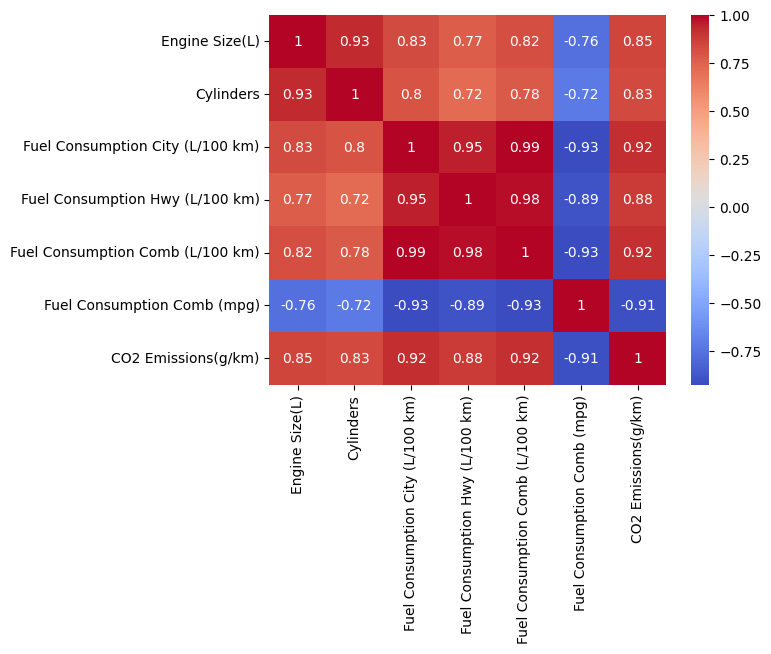

In [98]:
sns.heatmap(data_numeric.corr(), annot=True, cmap='coolwarm')

In [135]:
data_test = data[['Make', 'Vehicle_Class_Reduced', 'Engine Size(L)', 'Cylinders',
       'transmission_group', 'Fuel Type', 'Fuel Consumption City (L/100 km)',
       'Fuel Consumption Hwy (L/100 km)', 'Fuel Consumption Comb (L/100 km)',
       'Fuel Consumption Comb (mpg)', 'CO2 Emissions(g/km)']]

In [136]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
encoded_data = pd.DataFrame(encoder.fit_transform(data_test[['Make', 'Vehicle_Class_Reduced', 'transmission_group', 'Fuel Type']]))
encoded_data.columns = encoder.get_feature_names_out(['Make', 'Vehicle_Class_Reduced', 'transmission_group', 'Fuel Type'])
data_test = data_test.drop(['Make', 'Vehicle_Class_Reduced', 'transmission_group', 'Fuel Type'], axis=1)
data_test = pd.concat([data_test, encoded_data], axis=1)
data_test.head()

,Engine Size(L),Cylinders,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km),Make_ACURA,Make_ALFA ROMEO,Make_ASTON MARTIN,Make_AUDI,Make_BENTLEY,Make_BMW,Make_BUGATTI,Make_BUICK,Make_CADILLAC,Make_CHEVROLET,Make_CHRYSLER,Make_DODGE,Make_FIAT,Make_FORD,Make_GENESIS,Make_GMC,Make_HONDA,Make_HYUNDAI,Make_INFINITI,Make_JAGUAR,Make_JEEP,Make_KIA,Make_LAMBORGHINI,Make_LAND ROVER,Make_LEXUS,Make_LINCOLN,Make_MASERATI,Make_MAZDA,Make_MERCEDES-BENZ,Make_MINI,Make_MITSUBISHI,Make_NISSAN,Make_PORSCHE,Make_RAM,Make_ROLLS-ROYCE,Make_SCION,Make_SMART,Make_SRT,Make_SUBARU,Make_TOYOTA,Make_VOLKSWAGEN,Make_VOLVO,Vehicle_Class_Reduced_Car,Vehicle_Class_Reduced_Other,Vehicle_Class_Reduced_Pickup Truck,Vehicle_Class_Reduced_SUV,Vehicle_Class_Reduced_Station Wagon,Vehicle_Class_Reduced_Van,transmission_group_A,transmission_group_AM,transmission_group_AS,transmission_group_AV,transmission_group_M,Fuel Type_D,Fuel Type_E,Fuel Type_N,Fuel Type_X,Fuel Type_Z
0,2.0,4.0,9.9,6.7,8.5,33.0,196.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2.4,4.0,11.2,7.7,9.6,29.0,221.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,1.5,4.0,6.0,5.8,5.9,48.0,136.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,3.5,6.0,12.7,9.1,11.1,25.0,255.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,3.5,6.0,12.1,8.7,10.6,27.0,244.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [102]:
import pandas as pd; 
pd.set_option('display.max_rows', 1000); pd.set_option('display.max_columns', 1000); pd.set_option('display.width', 1000)

In [103]:
data_test.describe()

,Engine Size(L),Cylinders,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km),Make_ACURA,Make_ALFA ROMEO,Make_ASTON MARTIN,Make_AUDI,Make_BENTLEY,Make_BMW,Make_BUGATTI,Make_BUICK,Make_CADILLAC,Make_CHEVROLET,Make_CHRYSLER,Make_DODGE,Make_FIAT,Make_FORD,Make_GENESIS,Make_GMC,Make_HONDA,Make_HYUNDAI,Make_INFINITI,Make_JAGUAR,Make_JEEP,Make_KIA,Make_LAMBORGHINI,Make_LAND ROVER,Make_LEXUS,Make_LINCOLN,Make_MASERATI,Make_MAZDA,Make_MERCEDES-BENZ,Make_MINI,Make_MITSUBISHI,Make_NISSAN,Make_PORSCHE,Make_RAM,Make_ROLLS-ROYCE,Make_SCION,Make_SMART,Make_SRT,Make_SUBARU,Make_TOYOTA,Make_VOLKSWAGEN,Make_VOLVO,Vehicle_Class_Reduced_Car,Vehicle_Class_Reduced_Other,Vehicle_Class_Reduced_Pickup Truck,Vehicle_Class_Reduced_SUV,Vehicle_Class_Reduced_Station Wagon,Vehicle_Class_Reduced_Van,transmission_group_A,transmission_group_AM,transmission_group_AS,transmission_group_AV,transmission_group_M,Fuel Type_D,Fuel Type_E,Fuel Type_N,Fuel Type_X,Fuel Type_Z
count,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000
mean,3.161812,5.618911,12.610220,9.070583,11.017876,27.411016,251.157752,0.008118,0.003025,0.006208,0.041866,0.005571,0.079752,0.000318,0.014645,0.022445,0.081980,0.010188,0.028653,0.008914,0.091850,0.002229,0.046004,0.026106,0.029290,0.013849,0.018784,0.031837,0.030564,0.005890,0.012098,0.020535,0.012894,0.008278,0.020216,0.058103,0.031837,0.011621,0.033906,0.047119,0.011461,0.007641,0.003343,0.001114,0.000318,0.018943,0.043935,0.029768,0.018784,0.489335,0.091213,0.096784,0.257720,0.041229,0.023719,0.244508,0.085960,0.433301,0.074021,0.162209,0.023400,0.052531,0.000159,0.483763,0.440146
std,1.365201,1.846250,3.553066,2.278884,2.946876,7.245318,59.290426,0.089743,0.054917,0.078554,0.200298,0.074440,0.270930,0.017842,0.120137,0.148138,0.274356,0.100427,0.166843,0.094002,0.288837,0.047159,0.209511,0.159464,0.168632,0.116874,0.135772,0.175580,0.172146,0.076525,0.109333,0.141832,0.112826,0.090611,0.140751,0.233956,0.175580,0.107179,0.181003,0.211910,0.106451,0.087084,0.057726,0.033365,0.017842,0.136335,0.204967,0.169959,0.135772,0.499926,0.287935,0.295688,0.437414,0.198835,0.152183,0.429829,0.280327,0.495571,0.261826,0.368672,0.151183,0.223113,0.012617,0.499776,0.496444
min,0.900000,3.000000,4.200000,4.000000,4.100000,11.000000,96.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,4.000000,10.100000,7.500000,8.900000,22.000000,208.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

In [104]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7026 entries, 0 to 6263
Data columns (total 65 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Engine Size(L)                       6282 non-null   float64
 1   Cylinders                            6282 non-null   float64
 2   Fuel Consumption City (L/100 km)     6282 non-null   float64
 3   Fuel Consumption Hwy (L/100 km)      6282 non-null   float64
 4   Fuel Consumption Comb (L/100 km)     6282 non-null   float64
 5   Fuel Consumption Comb (mpg)          6282 non-null   float64
 6   CO2 Emissions(g/km)                  6282 non-null   float64
 7   Make_ACURA                           6282 non-null   float64
 8   Make_ALFA ROMEO                      6282 non-null   float64
 9   Make_ASTON MARTIN                    6282 non-null   float64
 10  Make_AUDI                            6282 non-null   float64
 11  Make_BENTLEY                       

In [ ]:
X = data_test.drop('CO2 Emissions(g/km)', axis=1)
Y = data_test['CO2 Emissions(g/km)']

# I used AI because i had a problem with missing values even though my database didn't have any missing values before encoding the categorical variables
X = X.fillna(X.mean())
Y = Y.fillna(Y.mean())


I had to standarize the data because it was on several different scales

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

y_mean = Y.mean()
y_std = Y.std()
Y_scaled = (Y - y_mean) / y_std

(7026, 64) (7026,)


In [ ]:
X_train, X_temp, Y_train, Y_temp = train_test_split(X_scaled, Y_scaled, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)
X_train.shape, X_val.shape, X_test.shape

((4918, 64), (1054, 64), (1054, 64))

In [ ]:
variable_number = X_train.shape[1]
print(variable_number)
model = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=(variable_number,)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


64


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,641 (65.00 KB)

 Trainable params: 16,641 (65.00 KB)

 Non-trainable params: 0 (0.00 B)

In [109]:
model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=100,)


Epoch 1/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1735 - mae: 0.2709 - val_loss: 0.1146 - val_mae: 0.2253
Epoch 2/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1150 - mae: 0.1978 - val_loss: 0.0949 - val_mae: 0.2028
Epoch 3/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1197 - mae: 0.1815 - val_loss: 0.0940 - val_mae: 0.1852
Epoch 4/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0673 - mae: 0.1507 - val_loss: 0.0812 - val_mae: 0.1699
Epoch 5/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0584 - mae: 0.1381 - val_loss: 0.0790 - val_mae: 0.1626
Epoch 6/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0538 - mae: 0.1319 - val_loss: 0.0796 - val_mae: 0.1645
Epoch 7/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0503 - mae: 0.1266 - val_loss: 0.0718 - val_mae: 0.1513
Epoch 8/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0501 - mae: 0.1242 - val_loss: 0.0728 - val_mae: 0.1534
Epoch 9/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/

In [110]:
predictions = model.predict(X_test)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


I used AI to get the denormalized values

In [111]:
y_pred = predictions.flatten() * y_std + y_mean
y_true = Y_test * y_std + y_mean

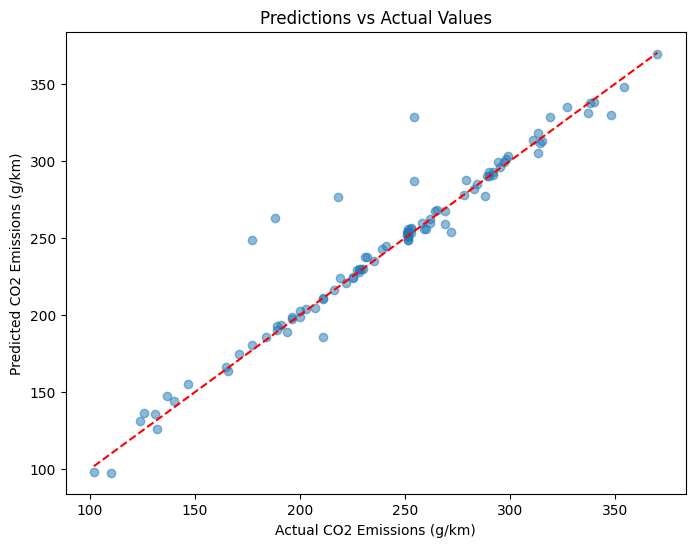

In [119]:
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel("Actual CO2 Emissions (g/km)")
plt.ylabel("Predicted CO2 Emissions (g/km)")
plt.title("Predictions vs Actual Values")
plt.show()

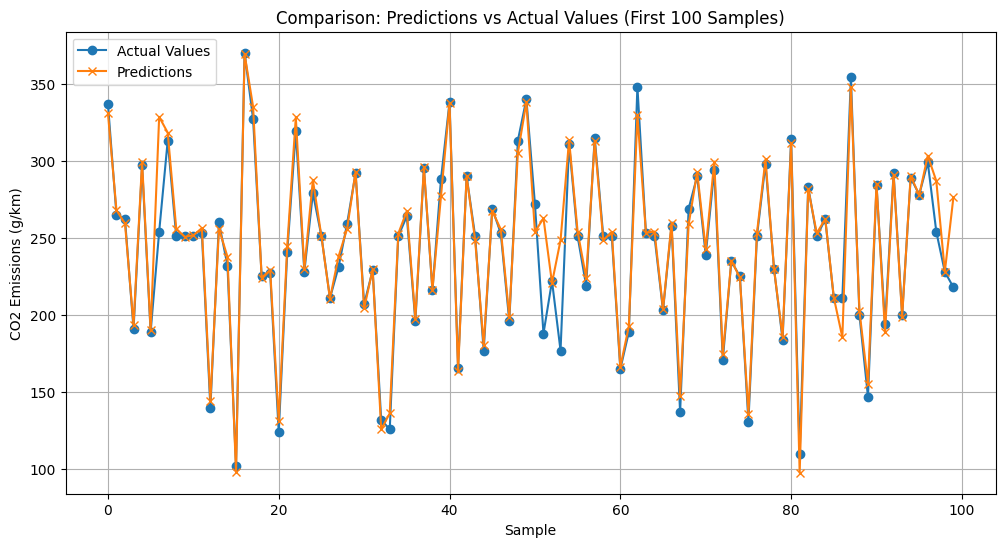

In [123]:

import matplotlib.pyplot as plt

n = 100
y_pred = y_pred[:n]
y_true = y_true.values[:n]

plt.figure(figsize=(12, 6))
plt.plot(range(n), y_true, label="Actual Values", marker='o')
plt.plot(range(n), y_pred, label="Predictions", marker='x')
plt.xlabel("Sample")
plt.ylabel("CO2 Emissions (g/km)")
plt.title("Comparison: Predictions vs Actual Values (First 100 Samples)")
plt.legend()
plt.grid(True)
plt.show()



Outliers are obvious here and they can affect the result we have 


Visualize also how well the prediction distribution follows the normal distribution (see code examples in Moodle).
Also, visualize how well the training process went visually (training loss). You
can also use a validation data set if you want more tools to see if the model
overfits.

In [126]:
data_test.columns

Index(['Engine Size(L)', 'Cylinders', 'Fuel Consumption City (L/100 km)', 'Fuel Consumption Hwy (L/100 km)', 'Fuel Consumption Comb (L/100 km)', 'Fuel Consumption Comb (mpg)', 'CO2 Emissions(g/km)', 'Make_ACURA', 'Make_ALFA ROMEO', 'Make_ASTON MARTIN', 'Make_AUDI', 'Make_BENTLEY', 'Make_BMW', 'Make_BUGATTI', 'Make_BUICK', 'Make_CADILLAC', 'Make_CHEVROLET', 'Make_CHRYSLER', 'Make_DODGE', 'Make_FIAT', 'Make_FORD', 'Make_GENESIS', 'Make_GMC', 'Make_HONDA', 'Make_HYUNDAI', 'Make_INFINITI', 'Make_JAGUAR', 'Make_JEEP', 'Make_KIA', 'Make_LAMBORGHINI', 'Make_LAND ROVER', 'Make_LEXUS', 'Make_LINCOLN', 'Make_MASERATI', 'Make_MAZDA', 'Make_MERCEDES-BENZ', 'Make_MINI', 'Make_MITSUBISHI', 'Make_NISSAN', 'Make_PORSCHE', 'Make_RAM', 'Make_ROLLS-ROYCE', 'Make_SCION', 'Make_SMART', 'Make_SRT', 'Make_SUBARU', 'Make_TOYOTA', 'Make_VOLKSWAGEN', 'Make_VOLVO', 'Vehicle_Class_Reduced_Car', 'Vehicle_Class_Reduced_Other', 'Vehicle_Class_Reduced_Pickup Truck', 'Vehicle_Class_Reduced_SUV',
       'Vehicle_Class_

C:\Users\Chourouk\AppData\Local\Temp\ipykernel_6828\3124725744.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_pred - y_true))


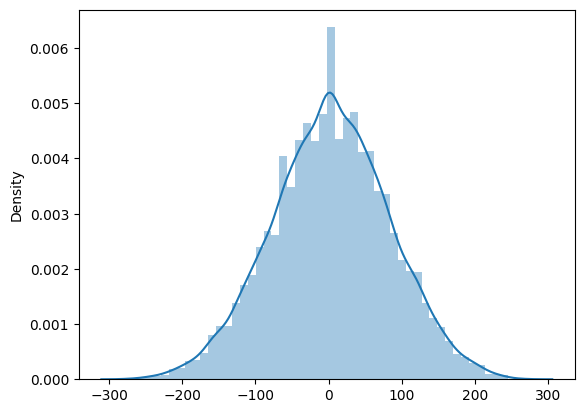

In [124]:
sns.distplot((y_pred - y_true))
plt.show()
plt.close()

<Axes: >

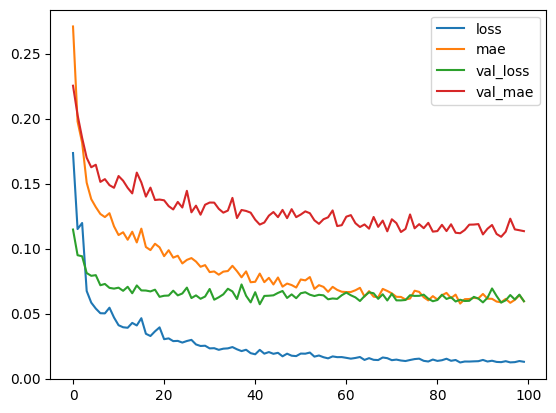

In [121]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [120]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = predictions * y_std + y_mean
y_true = Y_test * y_std + y_mean

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("Model evaluation :")
print(f" - MSE  : {mse:.2f} (g/km)^2")
print(f" - RMSE : {rmse:.2f} g/km")
print(f" - MAE  : +-{mae:.2f} g/km")
print(f" - R²   : {r2:.3f}")

Model evaluation :
 - MSE  : 724.78 (g/km)^2
 - RMSE : 26.92 g/km
 - MAE  : +-7.22 g/km
 - R²   : 0.783


In [127]:
data_test.columns

Index(['Engine Size(L)', 'Cylinders', 'Fuel Consumption City (L/100 km)', 'Fuel Consumption Hwy (L/100 km)', 'Fuel Consumption Comb (L/100 km)', 'Fuel Consumption Comb (mpg)', 'CO2 Emissions(g/km)', 'Make_ACURA', 'Make_ALFA ROMEO', 'Make_ASTON MARTIN', 'Make_AUDI', 'Make_BENTLEY', 'Make_BMW', 'Make_BUGATTI', 'Make_BUICK', 'Make_CADILLAC', 'Make_CHEVROLET', 'Make_CHRYSLER', 'Make_DODGE', 'Make_FIAT', 'Make_FORD', 'Make_GENESIS', 'Make_GMC', 'Make_HONDA', 'Make_HYUNDAI', 'Make_INFINITI', 'Make_JAGUAR', 'Make_JEEP', 'Make_KIA', 'Make_LAMBORGHINI', 'Make_LAND ROVER', 'Make_LEXUS', 'Make_LINCOLN', 'Make_MASERATI', 'Make_MAZDA', 'Make_MERCEDES-BENZ', 'Make_MINI', 'Make_MITSUBISHI', 'Make_NISSAN', 'Make_PORSCHE', 'Make_RAM', 'Make_ROLLS-ROYCE', 'Make_SCION', 'Make_SMART', 'Make_SRT', 'Make_SUBARU', 'Make_TOYOTA', 'Make_VOLKSWAGEN', 'Make_VOLVO', 'Vehicle_Class_Reduced_Car', 'Vehicle_Class_Reduced_Other', 'Vehicle_Class_Reduced_Pickup Truck', 'Vehicle_Class_Reduced_SUV',
       'Vehicle_Class_

In [128]:
data.describe(include='all')

,Make,Engine Size(L),Cylinders,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km),transmission_group,Vehicle_Class_Reduced
count,6282,6282.000000,6282.000000,6282,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282,6282
unique,42,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,5,6
top,FORD,NaN,NaN,X,NaN,NaN,NaN,NaN,NaN,AS,Car
freq,577,NaN,NaN,3039,NaN,NaN,NaN,NaN,NaN,2722,3074
mean,NaN,3.161812,5.618911,NaN,12.610220,9.070583,11.017876,27.411016,251.157752,NaN,NaN
std,NaN,1.365201,1.846250,NaN,3.553066,2.278884,2.946876,7.245318,59.290426,NaN,NaN
min,NaN,0.900000,3.000000,NaN,4.200000,4.000000,4.100000,11.000000,96.000000,NaN,NaN
25%,NaN,2.000000,4.000000,NaN,10.100000,7.500000,8.900000,22.000000,208.000000,NaN,NaN
50%,NaN,3.000000,6.000000,NaN,12.100000,8.700000,10.600000,27.000000,246.000000,NaN,NaN
75%,NaN,3.700000,6.000000,NaN,14.700000,10.300000,12.700000,32.000000,289.000000,NaN,NaN


In [129]:
data['Cylinders'].value_counts()

Cylinders
4     2749
6     2040
8     1202
12     135
3       88
10      40
5       26
16       2
Name: count, dtype: int64

In [147]:
data_test.shape
data_test.isna().sum()

Engine Size(L)                         744
Cylinders                              744
Fuel Consumption City (L/100 km)       744
Fuel Consumption Hwy (L/100 km)        744
Fuel Consumption Comb (L/100 km)       744
Fuel Consumption Comb (mpg)            744
CO2 Emissions(g/km)                    744
Make_ACURA                             744
Make_ALFA ROMEO                        744
Make_ASTON MARTIN                      744
Make_AUDI                              744
Make_BENTLEY                           744
Make_BMW                               744
Make_BUGATTI                           744
Make_BUICK                             744
Make_CADILLAC                          744
Make_CHEVROLET                         744
Make_CHRYSLER                          744
Make_DODGE                             744
Make_FIAT                              744
Make_FORD                              744
Make_GENESIS                           744
Make_GMC                               744
Make_HONDA 

I needed to do this because the dataset got messy and i didn't understand why
And even when i tried to clean it manually it wasn't possible it kept on getting the same problem

In [149]:
data_test.to_csv("CO2 Emissions_Canada_Cleaned.csv", index=False)
data_test_cleaned = pd.read_csv("CO2 Emissions_Canada_Cleaned.csv")
data_test_cleaned.isna().sum()

Engine Size(L)                         744
Cylinders                              744
Fuel Consumption City (L/100 km)       744
Fuel Consumption Hwy (L/100 km)        744
Fuel Consumption Comb (L/100 km)       744
Fuel Consumption Comb (mpg)            744
CO2 Emissions(g/km)                    744
Make_ACURA                             744
Make_ALFA ROMEO                        744
Make_ASTON MARTIN                      744
Make_AUDI                              744
Make_BENTLEY                           744
Make_BMW                               744
Make_BUGATTI                           744
Make_BUICK                             744
Make_CADILLAC                          744
Make_CHEVROLET                         744
Make_CHRYSLER                          744
Make_DODGE                             744
Make_FIAT                              744
Make_FORD                              744
Make_GENESIS                           744
Make_GMC                               744
Make_HONDA 

Testing the model based on a new data : picked one column for each

In [ ]:
x = np.random.randint(0, 2)
Test = {
    'Engine Size(L)': np.round(np.random.uniform(0.9, 8.4), 1),
    'Cylinders': np.random.choice([3, 4, 5, 6, 8, 10, 12, 16]),
    'Fuel Consumption City (L/100 km)': np.round(np.random.uniform(4.2, 30.6), 1),
    'Fuel Consumption Hwy (L/100 km)': np.round(np.random.uniform(4, 20.6), 1),
    'Fuel Consumption Comb (L/100 km)': np.round(np.random.uniform(4.1, 26.1), 1),
    'Fuel Consumption Comb (mpg)': np.round(np.random.uniform(11, 69), 1),
    'CO2 Emissions(g/km)': np.random.randint(96, 522),
    'Make_BMW': x,
    'Make_AUDI': 1 - x,
    'Vehicle_Class_Reduced_Car': x,
    'Vehicle_Class_Reduced_SUV': 1 - x,
    'transmission_group_A': x,
    'transmission_group_M': 1 - x,
    'Fuel Type_D': x,
    'Fuel Type_E': 1 - x
}

test_row = pd.DataFrame([Test])

for col in data_test.columns:
    if col not in test_row.columns:
        test_row[col] = 0

test_row = test_row[data_test.columns]

x_test_row = test_row.drop('CO2 Emissions(g/km)', axis=1)
y_test_row = test_row['CO2 Emissions(g/km)']

x_test_row = scaler.transform(x_test_row)
y_test_row = (y_test_row - y_mean) / y_std

y_pred_row = model.predict(x_test_row)
y_pred_row = y_pred_row.flatten() * y_std + y_mean
y_true_row = y_test_row * y_std + y_mean

print(f"Predicted CO2 Emissions: {y_pred_row[0]:.2f} g/km")
print(f"Actual CO2 Emissions: {y_true_row.values[0]:.2f} g/km")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted CO2 Emissions: 359.47 g/km
Actual CO2 Emissions: 323.00 g/km
